<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_12%5D_Abstractive_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12-13. 프로젝트: 뉴스기사 요약해보기

In [1]:
# 필요한 라이브러리 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

- 뉴스 기사 링크 불러오기

In [2]:
# 데이터 불러오기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인
print(data.shape)
data.sample(10)

# 98401개의 row와 2개의 columns를 가짐
# 데이터의 columns는 'headlines'과 'text'로 되었이다. 제목과 본문으로 생각하면 될거같다.
# 추상적 요약을 하는경우 text를 본문, headline을 요약된 데이터로 삼아서 학습
# 추출적 요약을 하는경우 오직 text열만을 사용

(98401, 2)


,headlines,text
47822,Most cryptocurrencies will go to zero: Ripple CEO,"Brad Garlinghouse, the CEO of the company behi..."
3394,Nearby galaxy to collide with Milky Way in 2.5...,Durham University astrophysicists have suggest...
84071,"Ma in Upma doesn't make it national dish, twee...",After Tamil movie director Radhakrishnan Parth...
25108,Ã¢ÂÂ¹100 crore needed to make ATMs ready for ...,The ATM operations industry on Friday said an ...
26724,Let paparazzi guess if papa is raazi:Ã¢ÂÂMah...,"Filmmaker Mahesh Bhatt, while commenting on hi..."
2923,I thank Satan for inspiration: Bale on playing...,While accepting Golden Globe award for 'Best a...
30124,Almost 200 athletes seek asylum in Australia a...,Almost 200 athletes have sought asylum in Aust...
13679,Congress' Chhattisgarh working Prez joins BJP ...,Congress' Chhattisgarh working President Ramda...
81774,Chinese zoo builds monument for live donkey fe...,A Chinese zoo has erected a monument in the me...
56029,"Suarez, Paulinho score braces in Barcelona's 4...",Uruguay's Luis Suarez and Brazil's Paulinho sc...


# Step 2. 데이터 전처리하기 (추상적 요약)

- 실습에 사용된 전처리 이외에 더 필요한 전처리를 수행하여 텍스트를 정규화 or 정제한다.

- 불용어 제거를 선택한다면 길이가 짧은 요약 데이터에 대해서도 불용어를 제거할 것인지 고민해보기

In [4]:
# 중복과 null 값 확인 후 제거하기
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# text열은 총 row개수에서 41개를 배제하고, headlines열은 총 row개수에서 121개를 배제한다.

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# 중복제거 시행
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

# 위에서 배제한 결과와 똑같이 처리되었다.

전체 샘플수 : 98360


In [6]:
# 결측값 확인하기
data.isnull().sum()

# 다행히 두 컬럼에는 결측치는 존재하지않았다.

headlines    0
text         0
dtype: int64

In [7]:
# 텍스트 정규화 수행
# 같은 의미지만 다른 표현으로 쓰이는 경우도 있다. 연산량을 줄이기 위해 정규화 과정이 필요하다.

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 불용어 확인
# NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개
print('불용어 개수 :', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수 구현
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# 전처리 전, 후의 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'our Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

# 결과를 보면 불용어를 제거하지 않은 것이 확인된다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: our great way to start the day


In [11]:
# 전체 Text 데이터에 대한 전처리
from tqdm import tqdm
clean_text = []

for s in tqdm(data['text']):
  clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [09:02<00:00, 181.39it/s]

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
# 전체 headlines 데이터에 대한 전처리 
clean_headlines = []

for s in tqdm(data['headlines']):
  clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98360/98360 [00:17<00:00, 5522.91it/s]

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
# 빈 샘플이 있는지 재확인
# 전처리 후의 결과를 다시 데이터프레임에 저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값은 ''으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# # 결측치 확인
data.isnull().sum()

# 결측치 없는 것으로 확인됨.

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


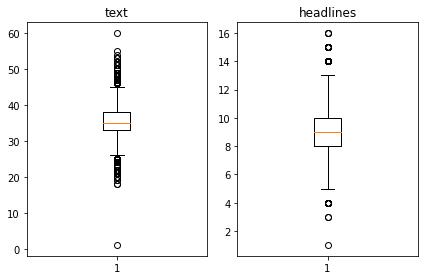

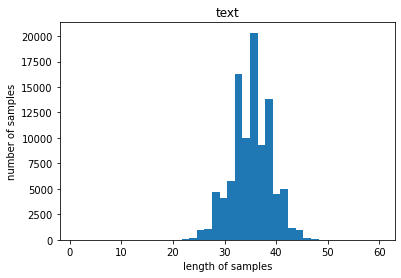

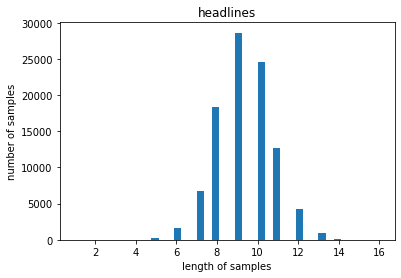

In [15]:
# 데이터 분리를 위한 sample의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 본문과 헤드라인의 길이 분포를 확인하고 적절한 max_len을 지정해야한다.

In [ ]:
# 첫 번째 시도
# Text 최대 길이
# 위 그래프를 참고할때 본문은 45, 헤드라인은 12로 결정하였다
text_max_len = 45
headlines_max_len = 12

In [ ]:
# 두 번째 시도
# Text 최대 길이
# 위 그래프를 참고할때 본문은 45, 헤드라인은 12로 결정하였다
text_max_len = 40
headlines_max_len = 11

In [16]:
# 세 번째 시도
# Text 최대 길이
# 위 그래프를 참고할때 본문은 45, 헤드라인은 12로 결정하였다
text_max_len = 38
headlines_max_len = 11

In [17]:
# 샘플 길이에따른 데이터 분포 확인
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
# 세 번째 시도
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

# 각각 45과 11로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, 
# Text 열의 경우에는 약 19%의 샘플들이 내용이 망가지게 된다고 한다.

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [19]:
# max_len 길이를 초과하는 데이터 제외시키기
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

# 첫 번째 시도에서 기존의 98360 sample에서 96871개로 줄어들었다.
# 두 번째 시도에서 기존의 98360 sample에서 85843개로 줄어들었다.
# 세 번째 시도에서 기존의 98360 sample에서 75754개로 줄어들었다.

전체 샘플수 : 75754


In [20]:
# data sample 확인
data.sample(5)

,headlines,text
61697,mla commenting on pm job twitter users troll a...,reacting ajit agarkar comments india must repl...
94717,soldiers trapped in avalanches in batalik rescued,five soldiers trapped army post thursday snowf...
57389,stokes named in england odi squad months after...,england ben stokes alex hales named england sq...
76105,us transgender troops sue trump over military ban,five transgender members us military sued pres...
94801,lakh withdrawal limit will not apply to banks ...,ban cash transactions excess lakh applicable w...


In [21]:
# 시작 토큰과 종료 토큰 추가하기

data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [22]:
# numpy 타입 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
# 데이터 분리
# 순서가 섞인 정수 시퀀스를 만들어줍니다.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22942 65789 35817 ... 55460 15993 13748]


In [24]:
# 정수시퀀스를 사용하여 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 훈련 / 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15150


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


In [27]:
# 단어 집합(vocabulary) 만들기 및 정수 인코딩
# 훈련 / 테스트 데이터의 단어들을 모두 정수로 바꿔주고 각 단어에 고유한 정수를 맵핑
# 이 과정을 단어 집합을 만든다고 표현

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
# 등장 빈도수에 따른 데이터 분포
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 세 번째 시도
# 등장빈도가 즉 9회 이하인 단어들은 단어 집합에서 약 74%정도 차지한다.
# 단어 집합에서 희귀 단어를 제외시킨 단어 집합의 크기는 15732개이다.
# 이를 어림잡아 단어 집합의 크기를 15000개로 제한하기로 결정한다

단어 집합(vocabulary)의 크기 : 60234
등장 빈도가 9번 이하인 희귀 단어의 수: 44527
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15707
단어 집합에서 희귀 단어의 비율: 73.92336554105655
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.383904387436972


등장 빈도수에 따른 train 데이터 분포
1. 첫 번째 시도

- 단어 집합(vocabulary)의 크기 : 69078
- 등장 빈도가 9번 이하인 희귀 단어의 수: 50829
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18249
- 단어 집합에서 희귀 단어의 비율: 73.58203769651698
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.602950321415036

2. 두 번째 시도

- 단어 집합(vocabulary)의 크기 : 64671
- 등장 빈도가 9번 이하인 희귀 단어의 수: 47635
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17036
- 단어 집합에서 희귀 단어의 비율: 73.65743532649874
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.956828223548855

3. 세 번째 시도

- 단어 집합(vocabulary)의 크기 : 60253
- 등장 빈도가 9번 이하인 희귀 단어의 수: 44521
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15732
- 단어 집합에서 희귀 단어의 비율: 73.89009675866762
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.378231136163988

In [29]:
# 단어장 생성

src_vocab = 15000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어장 크기 17000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[502, 21, 578, 412, 580, 5713, 41, 786, 3815, 53, 7905, 27, 6, 37, 152, 55, 7, 559, 1363, 7905, 36, 66, 5489, 989, 6, 7906, 404, 438, 1631, 404, 99, 7905, 810, 129, 29, 3], [41, 19, 1252, 316, 67, 2508, 160, 149, 2225, 24, 2038, 39, 901, 5638, 455, 13564, 1078, 39, 377, 3378, 678, 1078, 2508, 160, 2225, 363, 2038, 8, 3010, 690, 1, 316], [39, 19, 253, 160, 5363, 948, 2156, 642, 5040, 100, 8, 3303, 245, 80, 1603, 6, 2373, 5040, 5363, 122, 665, 1978, 1335, 392, 160, 328, 82, 42, 423, 1889, 1549, 245]]


In [31]:
# headlines 데이터도 동일하게 적용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 세번째 시도
# 등장빈도가 즉 5회 이하인 단어들은 단어 집합에서 약 66%정도 차지한다.
# 단어 집하에서 희귀 단어를 제외시킨 단어 집합의 크기는 9058개이다.
# 이를 어림잡아 단어 집합의 크기를 9000개로 제한하기로 결정한다.

단어 집합(vocabulary)의 크기 : 27022
등장 빈도가 5번 이하인 희귀 단어의 수: 17969
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9053
단어 집합에서 희귀 단어의 비율: 66.49766856635334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.5989400848062525


등장 빈도수에 따른 target 데이터 분포
1. 첫 번째 시도

- 단어 집합(vocabulary)의 크기 : 69078
- 등장 빈도가 9번 이하인 희귀 단어의 수: 50829
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18249
- 단어 집합에서 희귀 단어의 비율: 73.58203769651698
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.602950321415036

2. 두 번째 시도

- 단어 집합(vocabulary)의 크기 : 28471
- 등장 빈도가 5번 이하인 희귀 단어의 수: 18737
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9734
- 단어 집합에서 희귀 단어의 비율: 65.81082505005092
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.167682532194644

3. 세 번째 시도

- 단어 집합(vocabulary)의 크기 : 27068
- 등장 빈도가 5번 이하인 희귀 단어의 수: 18010
- 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9058
- 단어 집합에서 희귀 단어의 비율: 66.5361312250628
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.611303091177769

In [33]:
# 단어크기 제한(9000개)

tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시원스르 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 273, 962, 122, 683, 37, 2999, 34, 276, 61], [1, 1011, 322, 7, 2778, 221], [1, 91, 221, 3290, 3523, 502, 4341, 16, 1151, 4, 279], [1, 3000, 3524, 180, 2044, 4518, 3090, 1778, 1262, 336], [1, 104, 72, 2275, 3, 21, 7554, 6, 1600, 119]]
target
decoder  [[273, 962, 122, 683, 37, 2999, 34, 276, 61, 2], [1011, 322, 7, 2778, 221, 2], [91, 221, 3290, 3523, 502, 4341, 16, 1151, 4, 279, 2], [3000, 3524, 180, 2044, 4518, 3090, 1778, 1262, 336, 2], [104, 72, 2275, 3, 21, 7554, 6, 1600, 119, 2]]


In [34]:
# headlines의 길이가 1인 인덱스를 따로 저장해두기
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 삭제할 훈련 데이터의 개수는 없는 것으로 나옴

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60603
훈련 레이블의 개수 : 60603
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


In [35]:
# padding 수행
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

- 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있기 때문에 어텐션 매커니즘을 사용한다.

- 추가적으로 BiLSTM으로 인코더를 설계하면 어떨까? 라는 의문이 들어 더 좋은 성능을 낼 수 있는지 관련 근거를 찾아보았다.

[Bi-LSTM Hegemony](https://ratsgo.github.io/natural%20language%20processing/2017/10/22/manning/)

[Bi-LSTM 인코더 설계 참고 1](https://wikidocs.net/48920)
[Bi-LSTM 인코더 설계 참고 2](https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras)

이 블로그에서 어텐션과 bilstm이 적용된 모델이 nlp에서 좋은 성능을 내는 4가지 근거를 제시하였다.

- 종단간(End-to-end) 학습 : 출력값(output)에 대한 손실을 최소화하는 과정에서 모든 파라미터들이 동시에 학습된다.

- 분산표상(distributed representation) 사용 : 단어와 구(phrase) 간 유사성을 입력벡터에 내재화해 성능을 개선했다.

- 개선된 문맥 탐색(exploitation) : LSTM, 어텐션 등 덕분에 문장 길이가 길어져도 성능 저하를 막는다.

- 자연스런 문장생성 능력 : 다범주 분류에 좋은 성능을 내는 딥러닝 기법을 써서 문장 생성 능력이 큰 폭으로 개선됐다.


In [43]:
# lstm을 사용한 seq2seq
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
# Bilstm을 사용한 seq2seq
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 BiLSTM1
encoder_bilstm1 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bilstm1(enc_emb)
state_h1 = Concatenate()([forward_h1, backward_h1]) # 은닉 상태
state_c1 = Concatenate()([forward_c1, backward_c1]) # 셀 상태

# 인코더의 BiLSTM2
encoder_bilstm2 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bilstm2(encoder_output1)
state_h2 = Concatenate()([forward_h2, backward_h2]) # 은닉 상태
state_c2 = Concatenate()([forward_c2, backward_c2]) # 셀 상태

# 인코더의 BiLSTM3
encoder_bilstm3 = Bidirectional(LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.5))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm3(encoder_output2)
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [ ]:
# LSTM 모델 디코더
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# Bi-LSTM 모델 디코더
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size*2, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#  An `initial_state` was passed that is not compatible with `cell.state_size`. Received `
# state_spec`=ListWrapper([InputSpec(shape=(None, 512), ndim=2), InputSpec(shape=(None, 512), ndim=2)]); however `cell.state_size` is [256, 256]
# Bi-LSTM을 적용하다보니 hidden_size가 2배로 커진것으로 예상되어 hidden_size * 2로 바꿔주었다.

In [45]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1920000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 38, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [38]:
# Bi-LSTM 모델 디코더 출력층
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1920000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 38, 512),    788480      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                 

# 어텐션 메커니즘

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1920000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 38, 512),    788480      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                               

In [40]:
# Bi-LSTM 어텐션
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      1920000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 38, 512),    788480      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                               

In [47]:
# 모델 훈련 - 1 (lstm + 어텐션)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history1 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
237/237 [==============================] - 31s 84ms/step - loss: 6.1472 - val_loss: 5.7235
Epoch 2/50
237/237 [==============================] - 19s 79ms/step - loss: 5.6705 - val_loss: 5.5185
Epoch 3/50
237/237 [==============================] - 19s 81ms/step - loss: 5.3554 - val_loss: 5.1232
Epoch 4/50
237/237 [==============================] - 19s 82ms/step - loss: 4.9316 - val_loss: 4.7696
Epoch 5/50
237/237 [==============================] - 20s 83ms/step - loss: 4.5830 - val_loss: 4.5319
Epoch 6/50
237/237 [==============================] - 20s 84ms/step - loss: 4.3005 - val_loss: 4.3469
Epoch 7/50
237/237 [==============================] - 20s 85ms/step - loss: 4.0519 - val_loss: 4.1997
Epoch 8/50
237/237 [==============================] - 20s 85ms/step - loss: 3.8383 - val_loss: 4.1017
Epoch 9/50
237/237 [==============================] - 20s 85ms/step - loss: 3.6541 - val_loss: 4.0203
Epoch 10/50
237/237 [==============================] - 20s 85ms/step - loss: 3.494

In [41]:
# 모델 훈련 - 2 (bi-lstm + 어텐션)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history2 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
237/237 [==============================] - 58s 198ms/step - loss: 6.0466 - accuracy: 0.2346 - val_loss: 5.6693 - val_accuracy: 0.2623
Epoch 2/30
237/237 [==============================] - 48s 201ms/step - loss: 5.6135 - accuracy: 0.2625 - val_loss: 5.4464 - val_accuracy: 0.2756
Epoch 3/30
237/237 [==============================] - 48s 201ms/step - loss: 5.3297 - accuracy: 0.2744 - val_loss: 5.1305 - val_accuracy: 0.2881
Epoch 4/30
237/237 [==============================] - 48s 201ms/step - loss: 4.9592 - accuracy: 0.2898 - val_loss: 4.8306 - val_accuracy: 0.3019
Epoch 5/30
237/237 [==============================] - 48s 201ms/step - loss: 4.6499 - accuracy: 0.3048 - val_loss: 4.6424 - val_accuracy: 0.3141
Epoch 6/30
237/237 [==============================] - 48s 201ms/step - loss: 4.4097 - accuracy: 0.3189 - val_loss: 4.4988 - val_accuracy: 0.3233
Epoch 7/30
237/237 [==============================] - 48s 201ms/step - loss: 4.1974 - accuracy: 0.3319 - val_loss: 4.3883 - val_ac

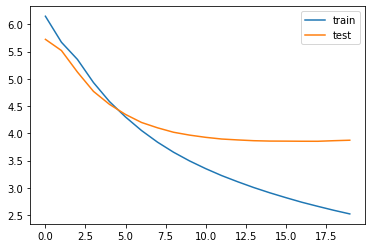

In [48]:
# 세 번째 시도 그래프
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

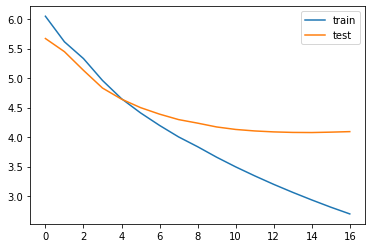

In [42]:
# Bi-LSTM + 어텐션 그래프
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# Bi-LSTM 인코더 설계
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size*2,))
decoder_state_input_c = Input(shape=(hidden_size*2,))
decoder_state_input = [decoder_state_input_h,decoder_state_input_c]
dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 =  decoder_lstm(dec_emb2, initial_state=decoder_state_input)

# hidden_size * 2를 적용하였다. 이유는 Bi-LSTM를 적용하였기 때문이다.

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size*2))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], 
    [decoder_outputs2] + [state_h2, state_c2]
)

In [48]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  # 시작 토큰 생성
  target_seq = np.zeros((1,1))
  target_seq[0,0] = tar_word_to_index['sostoken']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = tar_index_to_word[sampled_token_index]

    if (sampled_token != 'eostoken'):
      decoded_sentence += ' '+sampled_token
    
    #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
       stop_condition = True
     # 길이가 1인 타겟 시퀀스를 업데이트
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 상태를 업데이트 합니다.
    e_h, e_c = h, c

  return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환

def seq2text(input_seq):
  temp=''
  for i in input_seq:
    if (i != 0):
      temp = temp + src_index_to_word[i]+' '
  return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
      if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
          temp = temp + tar_index_to_word[i] + ' '
    return temp

In [54]:
# 학습 데이터 일부를 추출하여 실제 요약과 예측된 요약 비교
for i in range(1, 30):
  print("원문 :", seq2text(encoder_input_train[i]))
  print("실제 요약 :", seq2summary(decoder_input_train[i]))
  print("예측 요약 :", decode_sequence(encoder_input_train[i].reshape(1, text_max_len)))
  print("\n")

원문 : part one collection virat kohli designed first sneaker launched today kohli says basket classic one classic elements cricket available neutral colours white black sneakers design reflection kohli personal style 
실제 요약 : st ever virat kohli designed launched by 
예측 요약 :  virat kohli shares video of him on amazon


원문 : former jnu students union president kanhaiya kumar said environment fear india use patanjali face wash called anti national kanhaiya said various sections society including living fear demand reduction fee labelled anti national added 
실제 요약 : not using patanjali can make one anti national now kanhaiya 
예측 요약 :  not to make hindu universities jnu to ugc


원문 : delhi chief minister arvind kejriwal blue car stolen near secretariat delhi thursday evening delhi police reportedly registered complaint investigating matter car dubbed used kejriwal since activist currently used aam aadmi party functionary 
실제 요약 : cm kejriwal car stolen near delhi secretariat 
예측 요약 :  delhi

In [51]:
# 학습 데이터 일부를 추출하여 실제 요약과 예측된 요약 비교
for i in range(1, 50):
  print("원문 :", seq2text(encoder_input_train[i]))
  print("실제 요약 :", seq2summary(decoder_input_train[i]))
  print("예측 요약 :", decode_sequence(encoder_input_train[i].reshape(1, text_max_len)))
  print("\n")

원문 : bjp president amit shah called mahatma gandhi saying knew would happen congress future hence wanted dismantle independence congress special purpose vehicle independence mahatma gandhi knew going happen people completing job said shah 
실제 요약 : amit shah on mahatma gandhi 
예측 요약 :  bjp leader amit shah to make his own statue


원문 : congress president rahul gandhi convoy stopped shown black flags group people arrival karnataka sunday mob also threw flags convoy security personnel attempted clear area gandhi currently four day visit poll bound karnataka 
실제 요약 : rahul gandhi convoy shown black flags by mob in karnataka 
예측 요약 :  rahul gandhi convoy to visit srinagar hospital


원문 : indonesian pop band named seventeen performing live near beach saturday struck tsunami wave triggered volcanic eruption want say bass player manager passed away band member said band wife missing incident 
실제 요약 : tsunami wave hits indonesian pop band concert members missing 
예측 요약 :  dolphin in indonesia c

In [57]:
# 테스트 데이터 일부를 추출하여 실제 요약과 예측된 요약 비교
for i in range(1, 50):
  print("원문 :", seq2text(encoder_input_test[i]))
  print("실제 요약 :", seq2summary(decoder_input_test[i]))
  print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
  print("\n")

원문 : elon musk led tunnelling startup boring company unveiled sale priced musk claims device world flames shorter feet legal per bureau sale company also offering branded fire 
실제 요약 : elon musk boring company unveils 
예측 요약 :  musk boring company to build mn to musk


원문 : private lender icici bank duped lakh persons posing labour ministry employees police said saturday accused persons took loans amount submitting fake id cards ministry documents following discovery fraud bank employee registered complaint police 
실제 요약 : icici bank duped of by gang posing as ministry staff 
예측 요약 :  bank of directors of fake notes recovered from delhi


원문 : actor bjp leader shatrughan sinha took twitter urge actor rajinikanth take politics tamil nadu shatrughan tweeted hope wish pray titanic people darling dear friend tn super hero rajinikanth rises tweeted right time rajinikanth reach people 
실제 요약 : shatrughan in his tweets urges rajinikanth to join politics 
예측 요약 :  paresh rawal to be screened a

# Rouge score 사용해보기

가끔 NLP 분석을하고 이런 의문이 들었다.

accuracy말고 다른 평가지표도 분명 있지 않을까?

내가 한 시도들이 과연 개선된 결과를 가져오는지 매우 궁금하였다.

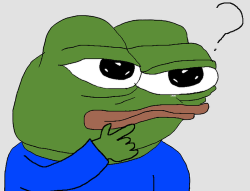

그래서 NLP에서 사용하는 평가 지표를 찾아보았고 BELU와 Rouge score를 찾았다.

문장 요약에서 사용하는 지표는 Rouge score이기 때문에 적용해보려한다.

[Rouge score 이론1](https://velog.io/@crosstar1228/NLPRouge-score-Summarization%EC%9D%98-%ED%8F%89%EA%B0%80-Metric#4-rouge-score%EC%9D%98-%EB%8B%A8%EC%A0%90)

[Rouge score 이론2](https://huffon.github.io/2019/12/07/rouge/)

[Rouge score 결과 해석 참고](https://pypi.org/project/rouge/)

1. ROUGE-N

N-gram의 개수가 기준

Rouge-1은 unigram, Rouge-2 는 bigram

Recall : output과 겹치는 N-gram의 수 / label의 N-gram의수

precision : label과 겹치는 N-gram의 수 / output의 N-gram의수

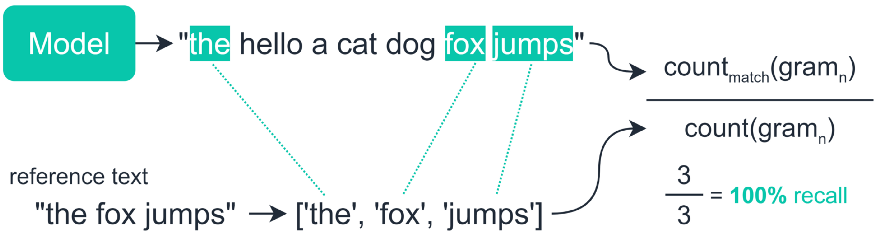

2. ROUGE-L
LCS(longest common sequence) between model output

말 그대로 common sequence 중에서 가장 긴 것을 매칭함

n-gram과 달리 순서나 위치관계를 고려한 알고리즘

Recall : LCS 길이 / label의 N-gram의수
Precision : LCS 길이 / output의 N-gram의수

In [53]:
# 라이브러리 설치
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=0aebe9d752a25a4e2637a0d8065b2ad7c3b2a9e5f05829494e53c8860eb8a806
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [91]:
# 라이브러리 설치
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
# 라이브러리 불러오기
from rouge import Rouge

In [78]:
# model_out 문장 추출 (input_train)
# 모델로부터 추론된 data를 output
model_out = []
for i in range(1, 1000):
  summary = decode_sequence(encoder_input_train[i].reshape(1, text_max_len))
  model_out.append(summary)

# 아쉬운 점은 랜덤추출을 하고싶었으나 코드적으로 구현하지못해 999개까지만 추출하여 비교해보았다.

In [98]:
# model_out 문장 추출 (input_test)
# 모델로부터 추론된 data를 output
model_out2 = []
for i in range(1, 1000):
  summary2 = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
  model_out2.append(summary2)

In [79]:
# label 문장 추출 (input_test)
# 사람이 요약한 Reference 정보를 label
label = []
for i in range(1, 1000):
  headline = seq2summary(decoder_input_train[i])
  label.append(headline)

In [99]:
# label 문장 추출 (input_train)
# 사람이 요약한 Reference 정보를 label
label2 = []
for i in range(1, 1000):
  headline2 = seq2summary(decoder_input_test[i])
  label2.append(headline2)

In [80]:
# 문장 개수 확인
print(len(model_out), len(label))

999 999


In [100]:
# 문장 개수 확인
print(len(model_out2), len(label2))

999 999


In [94]:
# Rouge score 출력 (input_train)
# get.scores를 사용하면 Rouge-1, Rouge-2, Rouge-l score 확인 가능
rouge = Rouge()
rouge.get_scores(model_out, label, avg=True)

# 오류메시지 : 'list' object has no attribute 'lower'
# 해결방법 : pip install rouge를 설치하여 문제 해결
# "f"는 f1_score, "p"는 정밀도, "r"은 재현율

{'rouge-1': {'r': 0.24168255557144502,
  'p': 0.27429492985048504,
  'f': 0.25314853783128355},
 'rouge-2': {'r': 0.07682007404229639,
  'p': 0.0833178416511751,
  'f': 0.07877579343197068},
 'rouge-l': {'r': 0.22416016304905237,
  'p': 0.2542332014554233,
  'f': 0.2347196569755021}}

In [101]:
# Rouge score 출력 (input_test)
# get.scores를 사용하면 Rouge-1, Rouge-2, Rouge-l score 확인 가능
rouge = Rouge()
rouge.get_scores(model_out2, label2, avg=True)

# 전체적으로 input_train 보다 input_output이 더 낮은 score를 보여주었다.
# 대부분 test가 train보다 정확도가 떨어지는 경향이있으므로 당연한 수치라고 생각한다.
# "f"는 f1_score, "p"는 정밀도, "r"은 재현율

{'rouge-1': {'r': 0.16197460086349014,
  'p': 0.18532381587937136,
  'f': 0.17016831604527302},
 'rouge-2': {'r': 0.03135119246230355,
  'p': 0.03401615901615902,
  'f': 0.032060189028602755},
 'rouge-l': {'r': 0.15113822336044594,
  'p': 0.1730111063444396,
  'f': 0.15879446927410945}}

결과를 출력하는 건 성공하였다.

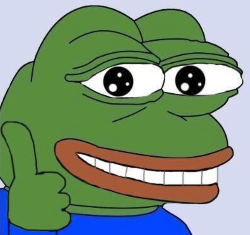

다만 만족스러운 수치는 아니다....

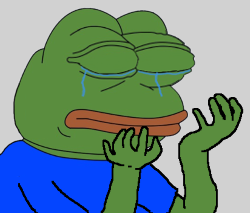

# Step 5. Summa을 이용해서 추출적 요약해보기

- 추출적 요약은 추상적 요약보다는 난이도가 낮다. 왜냐하면 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

In [4]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.5 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=0c4d0e619e6715b9ea235cf5c70be952e81e4d4fcef804df88ba7a87626ebf99
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
# 데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
74310,UAE envoy calls Saudi 'f***in coo coo' in leak...,UAE's envoy to the US Yousef Otaiba has report...
22793,Elon Musk-backed startup's AI beats humans at ...,Elon Musk-backed startup OpenAI's bot team Ope...
50507,Had found Delhi more conservative than Kabul: ...,Ex-Afghanistan President Hamid Karzai has said...
98190,Baahubali 2 trailer leak due to Facebook glitc...,'Baahubali 2' director SS Rajamouli said that ...
24612,Junior doctors of 5 MP medical colleges collec...,Junior doctors at five medical colleges in Mad...
18946,Samsung plans to stop TV production in India: ...,South Korean electronics giant Samsung is repo...
16942,Jenifer Lewis wears Nike at Emmys in support o...,Jenifer Lewis wore a Nike sweater with the bra...
58304,World's largest propeller plane lands at UK ai...,"The world's largest propeller plane, Antonov A..."
72450,Statue depicts Telangana IAS officer as mother...,A statue depicting Urban collector of Telangan...
96349,Sehwag awards Smith 'Tubelight' in #ViruGharel...,Virender Sehwag announced #ViruGhareluAwards o...


# summarize 사용하기

text (str) : 요약할 테스트.

ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.

split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [ ]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 30:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 추상적 요약에서 실제 원문의 내용까지 알아보기 힘들다는 느낌이 들었습니다. 전처리가 너무 과다하게 들어간 것이 아닐까? 라는 생각이 들었습니다.

 (2) 기존 lstm  + 어텐션에서 Bi-LSTM + 어텐션을 도전하려다보니 학습시키기까지 과정이 너무 힘들었습니다

 (3) 새로운 평가지표를 사용하기 위해서 실제 요약문과 모델이 요약한 결과를 출력할 때도 많은 어려움이 있었다. 하지만 잘 추출할 수 있었다.!!!
 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) NLP에서 사용하는 평가지표가 있다는 것을 알게되었습니다.

- BLEU

- ROUGE

Recall-Oriented Understudy for Gisting Evaluation

label(사람이 만든 요약문)과 summary(모델이 생성한 inference)을 비교해서 성능 계산

ROUGE-N, ROUGE-L, ROUGE-W, ROUGE-S 등 다양한 지표가 있음

Recall : label을 구성하는 단어 중 몇개가 inference와 겹치는가?
- 우선적으로 필요한 정보들이 다 담겨있는지 체크

precision : inference를 구성하는 단어 중 몇개가 label과 겹치는가?
- 요약된 문장에 필요한 정보만을 얼마나 담고있는지를 체크





참조

(1) [Rouge score](https://velog.io/@crosstar1228/NLPRouge-score-Summarization%EC%9D%98-%ED%8F%89%EA%B0%80-Metric#4-rouge-score%EC%9D%98-%EB%8B%A8%EC%A0%90)

(2) [Rouge score 이론2](https://huffon.github.io/2019/12/07/rouge/)

(3) [Rouge score 결과 해석 참고](https://pypi.org/project/rouge/)

(4) [BLEU Score(Bilingual Evaluation Understudy Score)](https://wikidocs.net/31695)

(5) [Bi-LSTM Hegemony](https://ratsgo.github.io/natural%20language%20processing/2017/10/22/manning/)

(6) [Bi-LSTM 인코더 설계 참고 1](https://wikidocs.net/48920)

(7) [Bi-LSTM 인코더 설계 참고 2](https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras)

